# Modelling

This notebook shows the process of training and tuning a model to fit to the data.

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
os.chdir('/app')

# read data
df = pd.read_csv('data/raw/creditcard.csv')

Using a **custom business cost function** takes into account the amount of a transaction when scoring, and weights false negatives higher than false positives.

- This is useful because a false negative on a high-value fraudulent transaction is far more costly than a false positive on a small legitimate one. By weighting errors according to transaction amount, the model can better align with true business impacts of misclassifications.

In [3]:
import sklearn
from sklearn.metrics import make_scorer

sklearn.set_config(enable_metadata_routing=True)

def business_cost(y_true, y_pred, amount):
    tp = (y_pred==1) & (y_true==1)
    tn = (y_pred==0) & (y_true==0)
    fp = (y_pred==1) & (y_true==0)
    fn = (y_pred==0) & (y_true==1)

    reward_tp = amount[tp].sum()
    reward_tn = 0.01 * amount[tn].sum()

    cost_fp = 0.1 * amount[fp].sum()
    cost_fn = 1.0 * amount[fn].sum()

    total_value = reward_tp + reward_tn - cost_fp - cost_fn

    return total_value / (sum(amount) + 1e-9)

business_scorer = (
    make_scorer(business_cost,greater_is_better=True)
    .set_score_request(amount=True)
)

Although the features are anonymised in the form of PC components, we can still derive further insight from looking at temporal trends, as noted in our EDA.

Ideally, we could include rolling amounts in both short and longer terms (over hours), although due to the lack of data, this isn't feasible. Instead we can look at rolling windows of the previous 5 transactions, the hour of day of payment, and time inbetween payments

In [4]:
# Feature engineering
df = df.sort_values('Time').reset_index(drop=True)

## Temporal features
df['Hour'] = (df['Time'] // 3600) % 24
df['delta_time'] = df['Time'].diff().fillna(0)

## Rolling PCA features
pca_cols = ['V1','V2','V3','V4','V5']
window_size = 5

for pc in pca_cols:
    df[f'{pc}_rolling_mean'] = df[pc].shift(1).rolling(window=window_size).mean()
    df[f'{pc}_rolling_std'] = df[pc].shift(1).rolling(window=window_size).std()
    df[f'{pc}_rolling_min'] = df[pc].shift(1).rolling(window=window_size).min()
    df[f'{pc}_rolling_max'] = df[pc].shift(1).rolling(window=window_size).max()
    df[f'{pc}_lag1'] = df[pc].shift(1)

## Rolling amount stats 
df['amount_rolling_sum'] = df['Amount'].shift(1).rolling(window=window_size).sum()

# Fill NaNs at the beginning of series
df.fillna(0, inplace=True)


In [5]:
# First, sort by Time
df = df.sort_values('Time').reset_index(drop=True)

# Features and target
X = df.drop(columns=['Class'])
y = df['Class']
amounts = df['Amount']

# Define fraction for training
train_frac = 0.7
train_idx = int(len(df) * train_frac)

# Chronological split
X_tr = X.iloc[:train_idx]
y_tr = y.iloc[:train_idx]
amount_tr = amounts.iloc[:train_idx]

X_test = X.iloc[train_idx:]
y_test = y.iloc[train_idx:]
amount_test = amounts.iloc[train_idx:]


In [6]:
X_tr.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V4_rolling_std,V4_rolling_min,V4_rolling_max,V4_lag1,V5_rolling_mean,V5_rolling_std,V5_rolling_min,V5_rolling_max,V5_lag1,amount_rolling_sum
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.0,0.0,0.0,1.378155,0.0,0.0,0.0,0.0,-0.338321,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.0,0.0,0.0,0.448154,0.0,0.0,0.0,0.0,0.060018,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.0,0.0,0.0,0.379780,0.0,0.0,0.0,0.0,-0.503198,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.0,0.0,0.0,-0.863291,0.0,0.0,0.0,0.0,-0.010309,0.0


In [7]:
y_tr.value_counts()

Class
0    198980
1       384
Name: count, dtype: int64

In [8]:
y_test.value_counts()

Class
0    85335
1      108
Name: count, dtype: int64

In [9]:
X_test.to_csv('services/mlflow/X_test.csv',index=False)
y_test.to_csv('services/mlflow/y_test.csv',index=False)

In [10]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TunedThresholdClassifierCV, TimeSeriesSplit, FixedThresholdClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("http://mlflow:5000")


# mlflow.create_experiment("Credit Card Fraud",)
mlflow.set_experiment("Credit Card Fraud",)

<Experiment: artifact_location='/mlflow/mlruns/1', creation_time=1761476318953, experiment_id='1', last_update_time=1761476318953, lifecycle_stage='active', name='Credit Card Fraud', tags={}>

## Baseline model 

A solid baseline model is predicting everything to be negative, from there we can compare scores against more advanced models to see if we do in fact improve on performance.

In [11]:
def predict_negative(y):
    return np.ones(y.shape[0])

print(f'train score:{business_cost(y_tr,predict_negative(y_tr),amount_tr)}')
print(f'test score:{business_cost(y_test,predict_negative(y_test),amount_test)}')

train score:-0.09719969147370373
test score:-0.09779459634332412


These scores mean that the baseline model has a net business value per dollar of total txn volume of ~ -9.8%, based on the custom business function.

As the score is negative - this means the business value costs > rewards of classifying transactions.

## Logistic Regression

In [40]:
lr = LogisticRegression(max_iter=500)

pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('logistic_regression',lr)
])

param_grid={'logistic_regression__C':[0.0001, 0.001, 0.01, 0.1, 1,
                 10, 100, 250, 500, 750, 1000, 1250, 5000, 10000, 100000]}

cv = GridSearchCV(pipeline,param_grid=param_grid,
                  cv=TimeSeriesSplit(n_splits=3), 
                  scoring=business_scorer,n_jobs=-1)

cv.fit(X_tr,y_tr,amount=amount_tr)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic_regression',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1,
             param_grid={'logistic_regression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                    10, 100, 250, 500, 750,
                                                    1000, 1250, 5000, 10000,
                                                    100000]},
             scoring=make_scorer(business_cost, response_method='predict'))

In [41]:
print(f'Best cross-validated C value: {cv.best_params_['logistic_regression__C']}')

Best cross-validated C value: 500


In [42]:
pipeline.set_params(logistic_regression__C=250)

tuned_cv = TunedThresholdClassifierCV(
    pipeline,
    scoring=business_scorer,
    cv=3,
    n_jobs=-1

)

tuned_cv.fit(X_tr,y_tr,amount=amount_tr)


TunedThresholdClassifierCV(cv=3,
                           estimator=Pipeline(steps=[('scaler',
                                                      StandardScaler()),
                                                     ('logistic_regression',
                                                      LogisticRegression(C=250,
                                                                         max_iter=500))]),
                           n_jobs=-1,
                           scoring=make_scorer(business_cost, response_method='predict'))

In [43]:
tuned_cv.best_threshold_

0.06060606060636097

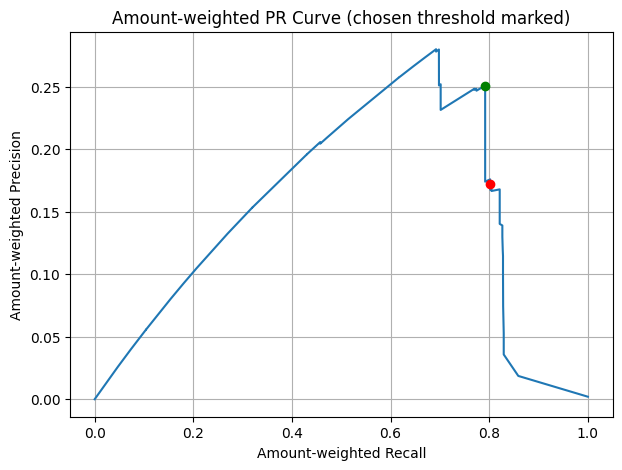

In [44]:
y_prob = cv.best_estimator_.predict_proba(X_test)[:, 1]

y_true = y_test.values if hasattr(y_test, "values") else y_test
amount = amount_test.values if hasattr(amount_test, "values") else amount_test


thresholds = np.linspace(0, 1, 500)

amount_precision = []
amount_recall = []

total_fraud_amount = amount[y_true == 1].sum()

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)

    tp = (y_pred == 1) & (y_true == 1)
    fp = (y_pred == 1) & (y_true == 0)

    fraud_caught = amount[tp].sum()
    amount_flagged = amount[tp | fp].sum()

    precision_amt = fraud_caught / (amount_flagged + 1e-9)
    recall_amt = fraud_caught / (total_fraud_amount + 1e-9)

    amount_precision.append(precision_amt)
    amount_recall.append(recall_amt)


import matplotlib.pyplot as plt


tuned_threshold = tuned_cv.best_threshold_

chosen_threshold=0.10

idx_chosen = np.argmin(np.abs(thresholds - chosen_threshold))
idx_tuned = np.argmin(np.abs(thresholds - tuned_threshold))

plt.figure(figsize=(7, 5))
plt.plot(amount_recall, amount_precision)
plt.scatter(amount_recall[idx_chosen], amount_precision[idx_chosen], color="green", zorder=5)
plt.scatter(amount_recall[idx_tuned], amount_precision[idx_tuned], color="red", zorder=5)
plt.xlabel("Amount-weighted Recall")
plt.ylabel("Amount-weighted Precision")
plt.title("Amount-weighted PR Curve (chosen threshold marked)")
plt.grid(True)
plt.show()



In [45]:
fixed_model = FixedThresholdClassifier(pipeline,threshold=0.1)
fixed_model.fit(X_tr,y_tr)

FixedThresholdClassifier(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                   ('logistic_regression',
                                                    LogisticRegression(C=250,
                                                                       max_iter=500))]),
                         threshold=0.1)

In [46]:
print(
    f'''
    Baseline logistic regression results\n
    CV best score (tuned): {tuned_cv.best_score_:.5f}
    Train score (tuned): {business_scorer(tuned_cv,X_tr,y_tr,amount=amount_tr):.5f}
    
    Test score (tuned): {business_scorer(tuned_cv,X_test,y_test,amount=amount_test):.5f}
    Test score (fixed): {business_scorer(fixed_model,X_test,y_test,amount=amount_test):.5f}
    '''
    
)

with mlflow.start_run(run_name='fixed_threshold_logistic_regression'):
    # # Log best parameters and metric
    mlflow.log_params(fixed_model.get_params())
    mlflow.log_metric("best_score_business", business_scorer(fixed_model,X_test,y_test,amount=amount_test))

    # Log the full trained pipeline
    from mlflow.models import infer_signature

    signature = infer_signature(X_tr, cv.predict(X_tr))
    mlflow.sklearn.log_model(
        sk_model=fixed_model,
        artifact_path="model",
        signature=signature
    )

    # Tag the run
    mlflow.set_tags({
        "model_type": "LogisticRegression",
        "custom_metric": "business_cost_function",
        "proba_decision_tuned": "True",
    })

with mlflow.start_run(run_name='tuned_threshold_logistic_regression'):
    # # Log best parameters and metric
    mlflow.log_params(tuned_cv.get_params())
    mlflow.log_metric("best_score_business", business_scorer(tuned_cv,X_test,y_test,amount=amount_test))

    # Log the full trained pipeline
    from mlflow.models import infer_signature

    signature = infer_signature(X_tr, cv.predict(X_tr))
    mlflow.sklearn.log_model(
        sk_model=fixed_model,
        artifact_path="model",
        signature=signature
    )

    # Tag the run
    mlflow.set_tags({
        "model_type": "LogisticRegression",
        "custom_metric": "business_cost_function",
        "proba_decision_tuned": "True",
    })
    


    Baseline logistic regression results

    CV best score (tuned): 0.01012
    Train score (tuned): 0.01051

    Test score (tuned): 0.01034
    Test score (fixed): 0.01063
    
🏃 View run fixed_threshold_logistic_regression at: http://mlflow:5000/#/experiments/1/runs/8712c2d910344803b80f13489583da96
🧪 View experiment at: http://mlflow:5000/#/experiments/1
🏃 View run tuned_threshold_logistic_regression at: http://mlflow:5000/#/experiments/1/runs/23a36eade0684c4c8c107051c5025acb
🧪 View experiment at: http://mlflow:5000/#/experiments/1


In [48]:
from sklearn.metrics import confusion_matrix, classification_report

print('Fixed Threshold model results')

y_pred = fixed_model.predict(X_test)

print("confusion matrix:")

print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))
print('\n')

print(f"Predicted fraud rate: {100*y_pred.mean():.2f}%")
print(f"Actual fraud rate:, {100*y_test.mean():.2f}%")


fn_loss = amount_test[(y_pred==0) & (y_test==1)].sum()
tn = amount_test[(y_test==1)].sum()


print(f'Total amount missed: ${fn_loss:.2f}')
print(f'Fraud amount coverage: {100*(1 - (fn_loss/tn)):.2f}%')

Fixed Threshold model results
confusion matrix:
[[85283    52]
 [   26    82]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       0.61      0.76      0.68       108

    accuracy                           1.00     85443
   macro avg       0.81      0.88      0.84     85443
weighted avg       1.00      1.00      1.00     85443



Predicted fraud rate: 0.16%
Actual fraud rate:, 0.13%
Total amount missed: $3033.68
Fraud amount coverage: 79.17%


## Histogram Gradient boosting

In [49]:
est = HistGradientBoostingClassifier(random_state=42,
                                     validation_fraction=0.2,
                                     max_iter=1000,
                                     )


pipeline = Pipeline([
    ('est',est)
])

In [93]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV


# Define parameter distributions
param_dist = {
    "est__learning_rate": np.linspace(0.01, 0.1, 20),
    "est__max_bins": np.arange(50, 256, 10),
    "est__max_depth": np.arange(20, 150, 10),
    "est__l2_regularization": np.logspace(-2, 0, 20),
    "est__max_features": np.linspace(0.1, 1.0, 10),
    "est__min_samples_leaf": np.arange(80, 150, 5),
    "est__max_leaf_nodes": np.arange(80, 200, 10),
}

# Create the HalvingRandomSearchCV object
cv = HalvingRandomSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    factor=3,
    resource='est__max_iter',
    max_resources=1000,
    min_resources=10,
    n_candidates=500,
    scoring=business_scorer,
    cv=TimeSeriesSplit(n_splits=3), 
    verbose=1,
    n_jobs=-1,
    random_state=42,
    return_train_score=False
)

# Fit the search
cv.fit(X_tr, y_tr, amount=amount_tr)



n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 10
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 500
n_resources: 10
Fitting 3 folds for each of 500 candidates, totalling 1500 fits
----------
iter: 1
n_candidates: 167
n_resources: 30
Fitting 3 folds for each of 167 candidates, totalling 501 fits
----------
iter: 2
n_candidates: 56
n_resources: 90
Fitting 3 folds for each of 56 candidates, totalling 168 fits


/usr/local/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 3
n_candidates: 19
n_resources: 270
Fitting 3 folds for each of 19 candidates, totalling 57 fits
----------
iter: 4
n_candidates: 7
n_resources: 810
Fitting 3 folds for each of 7 candidates, totalling 21 fits


HalvingRandomSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                      estimator=Pipeline(steps=[('est',
                                                 HistGradientBoostingClassifier(max_iter=1000,
                                                                                random_state=42,
                                                                                validation_fraction=0.2))]),
                      max_resources=1000, min_resources=10, n_candidates=500,
                      n_jobs=-1,
                      param_distributions={'est__l2_regularization': array([0.01      , 0.01274275, 0....
                                           'est__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                           'est__max_leaf_nodes': array([ 80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]),
                                           'est__min_samples_leaf': array([ 80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140,
       145])},
                      random_state=42, resource='est__max_iter',
                      return_train_score=False,
                      scoring=make_scorer(business_cost, response_method='predict'),
                      verbose=1)

In [95]:
print(f'Best parameters: {cv.best_params_}')

Best parameters: {'est__min_samples_leaf': 100, 'est__max_leaf_nodes': 120, 'est__max_features': 0.5, 'est__max_depth': 50, 'est__max_bins': 120, 'est__learning_rate': 0.06210526315789474, 'est__l2_regularization': 0.4832930238571752, 'est__max_iter': 810}


In [50]:
pipeline.set_params(est__min_samples_leaf=100,
                    est__max_leaf_nodes=120,
                    est__max_features=0.5,
                    est__max_depth=50,
                    est__max_bins=120,
                    est__learning_rate=0.62,
                    est__l2_regularization=0.48,
                    est__max_iter=850
                   )

tuned_cv = TunedThresholdClassifierCV(
    pipeline,
    scoring=business_scorer,
    cv=3,
    n_jobs=-1

)

tuned_cv.fit(X_tr,y_tr,amount=amount_tr)


TunedThresholdClassifierCV(cv=3,
                           estimator=Pipeline(steps=[('est',
                                                      HistGradientBoostingClassifier(l2_regularization=0.48,
                                                                                     learning_rate=0.62,
                                                                                     max_bins=120,
                                                                                     max_depth=50,
                                                                                     max_features=0.5,
                                                                                     max_iter=850,
                                                                                     max_leaf_nodes=120,
                                                                                     min_samples_leaf=100,
                                                                                     random_state=42,
                                                                                     validation_fraction=0.2))]),
                           n_jobs=-1,
                           scoring=make_scorer(business_cost, response_method='predict'))

In [51]:
tuned_cv.best_threshold_

0.32323232323232326

In [52]:
pipeline.fit(X_tr,y_tr)


Pipeline(steps=[('est',
                 HistGradientBoostingClassifier(l2_regularization=0.48,
                                                learning_rate=0.62,
                                                max_bins=120, max_depth=50,
                                                max_features=0.5, max_iter=850,
                                                max_leaf_nodes=120,
                                                min_samples_leaf=100,
                                                random_state=42,
                                                validation_fraction=0.2))])

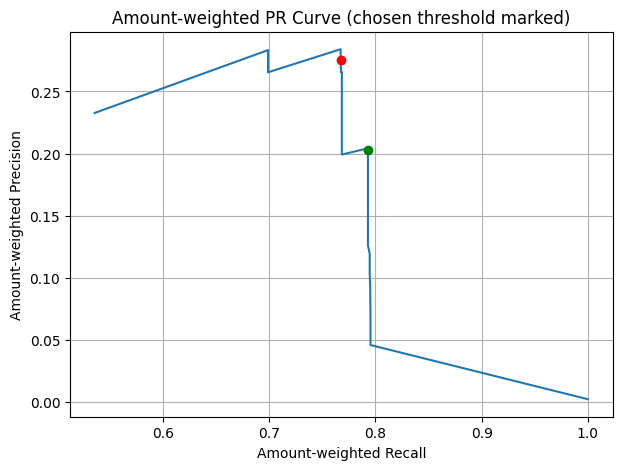

In [53]:
y_prob = pipeline.predict_proba(X_test)[:, 1]

y_true = y_test.values if hasattr(y_test, "values") else y_test
amount = amount_test.values if hasattr(amount_test, "values") else amount_test


thresholds = np.linspace(0, 1, 500)

amount_precision = []
amount_recall = []

total_fraud_amount = amount[y_true == 1].sum()

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)

    tp = (y_pred == 1) & (y_true == 1)
    fp = (y_pred == 1) & (y_true == 0)

    fraud_caught = amount[tp].sum()
    amount_flagged = amount[tp | fp].sum()

    precision_amt = fraud_caught / (amount_flagged + 1e-9)
    recall_amt = fraud_caught / (total_fraud_amount + 1e-9)

    amount_precision.append(precision_amt)
    amount_recall.append(recall_amt)


import matplotlib.pyplot as plt


tuned_threshold = tuned_cv.best_threshold_

chosen_threshold=0.04

idx_chosen = np.argmin(np.abs(thresholds - chosen_threshold))
idx_tuned = np.argmin(np.abs(thresholds - tuned_threshold))

plt.figure(figsize=(7, 5))
plt.plot(amount_recall, amount_precision)
plt.scatter(amount_recall[idx_chosen], amount_precision[idx_chosen], color="green", zorder=5)
plt.scatter(amount_recall[idx_tuned], amount_precision[idx_tuned], color="red", zorder=5)
plt.xlabel("Amount-weighted Recall")
plt.ylabel("Amount-weighted Precision")
plt.title("Amount-weighted PR Curve (chosen threshold marked)")
plt.grid(True)
plt.show()



In [54]:
fixed_model = FixedThresholdClassifier(pipeline,threshold=0.04)
fixed_model.fit(X_tr,y_tr)

FixedThresholdClassifier(estimator=Pipeline(steps=[('est',
                                                    HistGradientBoostingClassifier(l2_regularization=0.48,
                                                                                   learning_rate=0.62,
                                                                                   max_bins=120,
                                                                                   max_depth=50,
                                                                                   max_features=0.5,
                                                                                   max_iter=850,
                                                                                   max_leaf_nodes=120,
                                                                                   min_samples_leaf=100,
                                                                                   random_state=42,
                                                                                   validation_fraction=0.2))]),
                         threshold=0.04)

In [39]:
print(
    f'''
    Baseline logistic regression results\n
    CV best score (tuned): {tuned_cv.best_score_:.5f}
    Train score (tuned): {business_scorer(tuned_cv,X_tr,y_tr,amount=amount_tr):.5f}
    
    Test score (tuned): {business_scorer(tuned_cv,X_test,y_test,amount=amount_test):.5f}
    Test score (fixed): {business_scorer(fixed_model,X_test,y_test,amount=amount_test):.5f}
    '''
    
)

with mlflow.start_run(run_name='fixed_threshold_XGB'):
    # # Log best parameters and metric
    mlflow.log_params(fixed_model.get_params())
    mlflow.log_metric("best_score_business", business_scorer(fixed_model,X_test,y_test,amount=amount_test))

    # Log the full trained pipeline
    from mlflow.models import infer_signature

    signature = infer_signature(X_tr, cv.predict(X_tr))
    mlflow.sklearn.log_model(
        sk_model=fixed_model,
        artifact_path="model",
        signature=signature
    )

    # Tag the run
    mlflow.set_tags({
        "model_type": "HistGradientBoost",
        "custom_metric": "business_cost_function",
        "proba_decision_tuned": "True",
    })

with mlflow.start_run(run_name='tuned_threshold_XGB'):
    # # Log best parameters and metric
    mlflow.log_params(tuned_cv.get_params())
    mlflow.log_metric("best_score_business", business_scorer(tuned_cv,X_test,y_test,amount=amount_test))

    # Log the full trained pipeline
    from mlflow.models import infer_signature

    signature = infer_signature(X_tr, cv.predict(X_tr))
    mlflow.sklearn.log_model(
        sk_model=fixed_model,
        artifact_path="model",
        signature=signature
    )

    # Tag the run
    mlflow.set_tags({
        "model_type": "HistGradientBoost",
        "custom_metric": "business_cost_function",
        "proba_decision_tuned": "True",
    })
    


    Baseline logistic regression results

    CV best score (tuned): 0.00973
    Train score (tuned): 0.01218

    Test score (tuned): 0.01061
    Test score (fixed): 0.01016
    
🏃 View run fixed_threshold_XGB at: http://mlflow:5000/#/experiments/1/runs/60496d770a9d4eeaa71fd3b2f78a69b5
🧪 View experiment at: http://mlflow:5000/#/experiments/1
🏃 View run tuned_threshold_XGB at: http://mlflow:5000/#/experiments/1/runs/427b6d0653504f8fbc0a49dd437cd73b
🧪 View experiment at: http://mlflow:5000/#/experiments/1


In [55]:
from sklearn.metrics import confusion_matrix, classification_report
print('Tuned threshold model results')

y_pred = tuned_cv.predict(X_test)

print("confusion matrix:")

print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))
print('\n')

print(f"Predicted fraud rate: {100*y_pred.mean():.2f}%")
print(f"Actual fraud rate:, {100*y_test.mean():.2f}%")


fn_loss = amount_test[(y_pred==0) & (y_test==1)].sum()
tn = amount_test[(y_test==1)].sum()

print(f'Total amount missed: ${fn_loss:.2f}')
print(f'Fraud amount coverage: {100*(1 - (fn_loss/tn)):.2f}%')

Tuned threshold model results
confusion matrix:
[[85283    52]
 [   35    73]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       0.58      0.68      0.63       108

    accuracy                           1.00     85443
   macro avg       0.79      0.84      0.81     85443
weighted avg       1.00      1.00      1.00     85443



Predicted fraud rate: 0.15%
Actual fraud rate:, 0.13%
Total amount missed: $3391.38
Fraud amount coverage: 76.72%


Exception ignored in: <function ResourceTracker.__del__ at 0xffff96d95c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0xffffa9795c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0xffffaa529c60>
Traceback (most recent call last):
  File "/usr

In [9]:
import mlflow
mlflow.pyfunc.get_model_dependencies("models:/credit-card-fraud/1") 

2025/10/26 20:30:13 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r /mlflow/mlruns/1/e41f223625564844b2f77877892809f6/artifacts/model/requirements.txt'.


'/mlflow/mlruns/1/e41f223625564844b2f77877892809f6/artifacts/model/requirements.txt'

In [47]:
def parse_mlflow_params(raw_params, step_name='est'):
    parsed_params = {}
    for k, v in raw_params.items():
        if not k.startswith(f'{step_name}__'):
            continue
        param_name = k.replace(f'{step_name}__', '')
        # Try to cast to float or int
        try:
            if '.' in v:
                parsed_params[f'{step_name}__{param_name}'] = float(v)
            else:
                parsed_params[f'{step_name}__{param_name}'] = int(v)
        except ValueError:
            parsed_params[f'{step_name}__{param_name}'] = v  # Leave as string
    return parsed_params

params = mlflow.get_run('471943aa6e074b1e864978d7156931f0').data.params
clean_params = parse_mlflow_params(params)
pipeline.set_params(**clean_params)

Pipeline(steps=[('scaler', StandardScaler()),
                ('est',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=0.29763514416313175,
                                                learning_rate=0.09526315789473684,
                                                max_bins=60, max_depth=50,
                                                max_features=0.4, max_iter=10,
                                                max_leaf_nodes=100,
                                                min_samples_leaf=125,
                                                random_state=42,
                                                validation_fraction=0.2))])

In [39]:
import requests

url = "http://mlflow-serve:1234/invocations"
headers = {"Content-Type": "application/json"}

# Example input — depends on what your model expects!
# Must be a pandas-compatible JSON (records-orient)
data = {
    "dataframe_split": {
        "columns": list(X.columns),
        "data": [X.loc[215984].values.tolist()]  # <- a single prediction row
    }
}

response = requests.post(url, json=data, headers=headers)
print("Prediction:", response.json())


Prediction: {'predictions': [1]}
